## Importing packages

In [1]:
#import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pydpc import Cluster
%matplotlib inline
import scipy.io 

In [2]:
import sys

In [3]:
sys.executable

'/anaconda3/envs/lau/bin/python'

## Class definitions

In [4]:
class lib_data(object):
    
    def size_rank(self): #this needed to be defined before the __init__ because it needs to be run during the __init__ if the initializing data is in dataframe format
        self.lib_size = np.sum(self.lib_counts,axis=1) #calculate 
        self.lib_rank = np.argsort(self.lib_size)[::-1]
        self.mt_mouse_mask = pd.Series( self.lib_counts.columns).str.contains('mt-').values # startswith() is case sensitive
        self.mt_human_mask = pd.Series( self.lib_counts.columns).str.contains('MT-').values # startswith() is case sensitive
        self.lib_rank_inflec = None 
        
    def __init__(self,hdf5_file = None,lib_counts = None):
        self.hdf5 = hdf5_file
        self.lib_counts = lib_counts #main array of count data
        if (hdf5_file == None):
            self.size_rank()

    def hdf5_to_counts(self):
        #need to put some kind of checker here to make sure that first index of datasets is actually counts and not vice versa 
        self.lib_counts=pd.DataFrame(self.hdf5['Top_Counts'].value)
        transcriptsIn=pd.DataFrame(self.hdf5['Transcripts'].value)
        barcodesIn=pd.DataFrame(self.hdf5['Barcodes'].value)
        transcriptsIn=list(transcriptsIn[0].apply(lambda x: x.decode('utf-8'))) #decode bytes to utf-8
        barcodesIn=list(barcodesIn[0].apply(lambda x: x.decode('utf-8'))) #decode bytes to utf-8
        self.lib_counts.columns=transcriptsIn
        self.lib_counts.index=barcodesIn
        self.size_rank()
        
    def marker_percent(self,mask):
        marker_sum = np.sum( self.lib_counts.iloc[:,mask].values, axis=1)
        return marker_sum/self.lib_size.astype(float)*100 #percent of counts that are mitochondrial given all counts in cell
           
    def find_inflection(self):
        
        cumsum=np.cumsum(self.lib_size)
        length=len(cumsum)
        x_vals=np.arange(0,length)
        secant_coef=cumsum[length-1]/length
        secant_line=secant_coef*x_vals
        secant_dist=abs(cumsum-secant_line)
        max_dist=np.where(np.max(secant_dist)==secant_dist)[0][0]
        plt.figure(figsize=(20,10))
        plt.plot(np.array(cumsum), label="Cumulative Sum")
        plt.plot(np.array(secant_line), label="Secant Line")
        plt.plot(np.array(secant_dist), label="CS-SL Distance")
        plt.axvline(x=max_dist,c='red',linestyle='--',linewidth=1,label="Inflection Point")
        plt.legend()
        self.lib_rank_inflec = np.sort(np.where(self.lib_rank<max_dist)).ravel()
        print("Inflection point at {}".format(max_dist))
        
    def top_n_lib_counts(self,inflec):
        top_n_output = self.lib_counts.iloc[inflec,:]
        return top_n_output

In [5]:
class dimension_reduction(object):
    
    def __init__(self,lib_data_in,seed = 42):
        self.lib_data = lib_data_in.lib_counts
        self.lib_size = lib_data_in.lib_size
        self.lib_rank = lib_data_in.lib_rank
        self.seed = seed
        np.random.seed(self.seed)

    def normalize_arcsinh(self,cofactor):
        self.lib_data = np.arcsinh(self.lib_data.div(self.lib_size.values,axis = 'rows')*cofactor)
        
    def runPCA(self,n_pcs):
        _pca = PCA(n_components = n_pcs)
        self.PCA = _pca.fit(self.lib_data).transform(self.lib_data)
    
    def runUMAP(self,n_neighbors = 10,min_dist = 0.5):
        self.UMAP = umap.UMAP(n_neighbors = n_neighbors, min_dist = min_dist, metric = 'correlation').fit_transform(self.PCA)
        
    def runTSNE(self,n_components=2):
        self.TSNE = TSNE(n_components=n_components,n_iter=5000,metric='euclidean',init='pca',random_state=self.seed).fit_transform(self.PCA)

In [6]:
class gate_thresh(object):
    
    def __init__(self,dr_in):
        self.PCA = dr_in.PCA
        #self.UMAP = dr_in.UMAP
        self.TSNE = dr_in.TSNE
        self.seed = dr_in.seed
        self.lib_rank = dr_in.lib_rank
        self.DPC = None
        
    def plotPCA(self):
        fig = plt.figure(figsize=(16,16))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)

        ax1.scatter(self.PCA[:,0],self.PCA[:,1],alpha=0.5, s=20)
        ax2.scatter(self.PCA[:,1],self.PCA[:,2],alpha=0.5, s=20)
        ax3.scatter(self.PCA[:,2],self.PCA[:,3],alpha=0.5, s=20)
        ax4.scatter(self.PCA[:,3],self.PCA[:,4],alpha=0.5, s=20)

        ax1.set_xlabel( "PC_0")
        ax1.set_ylabel( "PC_1")
        ax2.set_xlabel( "PC_1")
        ax2.set_ylabel( "PC_2")
        ax3.set_xlabel( "PC_2")
        ax3.set_ylabel( "PC_3")
        ax4.set_xlabel( "PC_3")
        ax4.set_ylabel( "PC_4")
    
    def plotUMAP(self,marker_overlay):
        cmap_rank = plt.cm.get_cmap('seismic_r')
        cmap_marker = plt.cm.get_cmap('viridis')
        cmap_clust=plt.cm.get_cmap('tab20', len(self.DPC.clusters))

        fig = plt.figure(figsize=(30,10))
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133)
        
        rank = ax1.scatter(self.UMAP[:,0],self.UMAP[:,1],alpha=1, s=20,c = self.lib_rank,cmap = cmap_rank)
        mito = ax2.scatter(self.UMAP[:,0],self.UMAP[:,1],alpha=1, s=20,c = marker_overlay,cmap = cmap_marker)
        clust = ax3.scatter(self.UMAP[:,0],self.UMAP[:,1],alpha=1, s=20,c = self.DPC.membership,cmap = cmap_clust) 
        
        plt.colorbar(rank, ax = ax1)
        plt.colorbar(mito, ax = ax2)
        plt.colorbar(clust, ax = ax3,ticks=range(len(self.DPC.clusters)))
        
        ax1.set_xlabel("Ranking")
        ax2.set_xlabel("Marker Enrichment")
        ax3.set_xlabel("Density Peak Clustering")
    
    def plotTSNE(self,marker_overlay):
        cmap_rank = plt.cm.get_cmap('seismic_r')
        cmap_marker = plt.cm.get_cmap('viridis')
        cmap_clust=plt.cm.get_cmap('tab20', len(self.DPC.clusters))

        fig = plt.figure(figsize=(30,10))
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133)
        
        rank = ax1.scatter(self.TSNE[:,0],self.TSNE[:,1],alpha=1, s=20,c = self.lib_rank,cmap = cmap_rank)
        mito = ax2.scatter(self.TSNE[:,0],self.TSNE[:,1],alpha=1, s=20,c = marker_overlay,cmap = cmap_marker)
        clust = ax3.scatter(self.TSNE[:,0],self.TSNE[:,1],alpha=1, s=20,c = self.DPC.membership,cmap = cmap_clust) 
        
        plt.colorbar(rank, ax = ax1)
        plt.colorbar(mito, ax = ax2)
        plt.colorbar(clust, ax = ax3,ticks=range(len(self.DPC.clusters)))
        
        ax1.set_xlabel("Ranking")
        ax2.set_xlabel("Marker Enrichment")
        ax3.set_xlabel("Density Peak Clustering")
    
    def runDPC(self,dr,x_cutoff,y_cutoff,force_rerun = False):
        if ((self.DPC == None) or (force_rerun == True)):
            self.DPC = Cluster(dr.astype('float64'))
        self.DPC.assign(x_cutoff,y_cutoff)
        
    def manual_gating(self,gate_out):
        clust_inds = np.delete(np.arange(0,len(self.DPC.membership),1),gate_out) # clusters that represent cells to keep
        clust_mask = np.isin(self.DPC.membership, clust_inds)
        gated_embedding = self.TSNE[clust_mask]
        gated_ranking = self.lib_rank[clust_mask]

        cmap_rank = plt.cm.get_cmap('seismic_r')
        fig = plt.figure(figsize=(10,10))
        ax1 = fig.add_subplot(111)
        rank = ax1.scatter(gated_embedding[:,0],gated_embedding[:,1],alpha=1,s=20,c = gated_ranking,cmap = cmap_rank)
        plt.colorbar(rank, ax = ax1)
        
        ax1.set_xlabel("Gated Ranking")
        
        return (clust_mask)

In [7]:
def library_sorting(data_df): #Library sorting function by Sarah Maddox
    return(data_df.reindex(data_df.sum(axis = 1).sort_values().index, axis=0))

## Reading and data from .csv file and initializing lib_data object

In [8]:
dataIn=pd.read_csv("https://www.dropbox.com/s/y1iz4rt67s4e8es/Example_dataset.csv?dl=1",index_col=0)

In [9]:
dataIn.head()

,hg19_C1QTNF1,hg19_RP11-706O15.7,mm10_Hnrnpl,hg19_ANXA5,hg19_SHMT2,mm10_mt-Nd5,mm10_Asna1,hg19_COX17,hg19_CD81,hg19_HAGH,...,hg19_C17orf112,hg19_SLC12A1,mm10_Fam83c,hg19_GPR39,hg19_AP000640.2,mm10_1600002D24Rik,hg19_RP11-950C14.7,mm10_RP24-118K20.1,hg19_HCRT,hg19_PDHA2
ACTAATTGGATCGTTT,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TAATCCATGACGATGG,0,0,0,3,1,0,0,3,1,0,...,0,0,0,0,0,0,0,0,0,0
GGGCATCACTACGAGC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACTGGTCACTTCTTCG,0,0,0,1,0,0,0,5,2,0,...,0,0,0,0,0,0,0,0,0,0
CTGGGTATTAGTCTAG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
dataInSorted = library_sorting(dataIn) 

Now we pass it directly into the object for initialization, This will temporarily spike RAM usage.

In [11]:
indrops_data=lib_data(lib_counts=dataInSorted)

Here, we check to see that the dataframe was passed properly into the object, it should look identical to the raw dataframe 

In [12]:
indrops_data.lib_counts.head()

,hg19_C1QTNF1,hg19_RP11-706O15.7,mm10_Hnrnpl,hg19_ANXA5,hg19_SHMT2,mm10_mt-Nd5,mm10_Asna1,hg19_COX17,hg19_CD81,hg19_HAGH,...,hg19_C17orf112,hg19_SLC12A1,mm10_Fam83c,hg19_GPR39,hg19_AP000640.2,mm10_1600002D24Rik,hg19_RP11-950C14.7,mm10_RP24-118K20.1,hg19_HCRT,hg19_PDHA2
GGCACTTCCTCGATGC,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ATGTGCCGGTATGAGT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ATTTGTTGTGATGCCC,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
CCCGTTCTCTTCAGGT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCATCGAGACGGTAGC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Once the object has been properly initialized, everything else can be performed the same.

## Inflection Point Thresholding

We need to perform inflection point thresholding as a low cost/high performance method to quickly select for the cells with libraries that contribute significantly to the cumulative counts of the entire dataset.

The current inflection point finding method assumes that the libraries have been sorted by size: greatest to least or least to greatest, the inflection should be detectable. Future versions will include sorting methods.

Note that sometimes a fair amount of leeway should be included in inflection point definition. As a more generous threshold (which includes a handful of lower count libraries), can often capture rarer cell populations whose quality will be controlled for in downstream gating based analyses. For example, though our algorithm defines the inflection point as 1608, we could set it at 1500 to capture 500 cells who may have some interesting properties.  

Inflection point at 1608


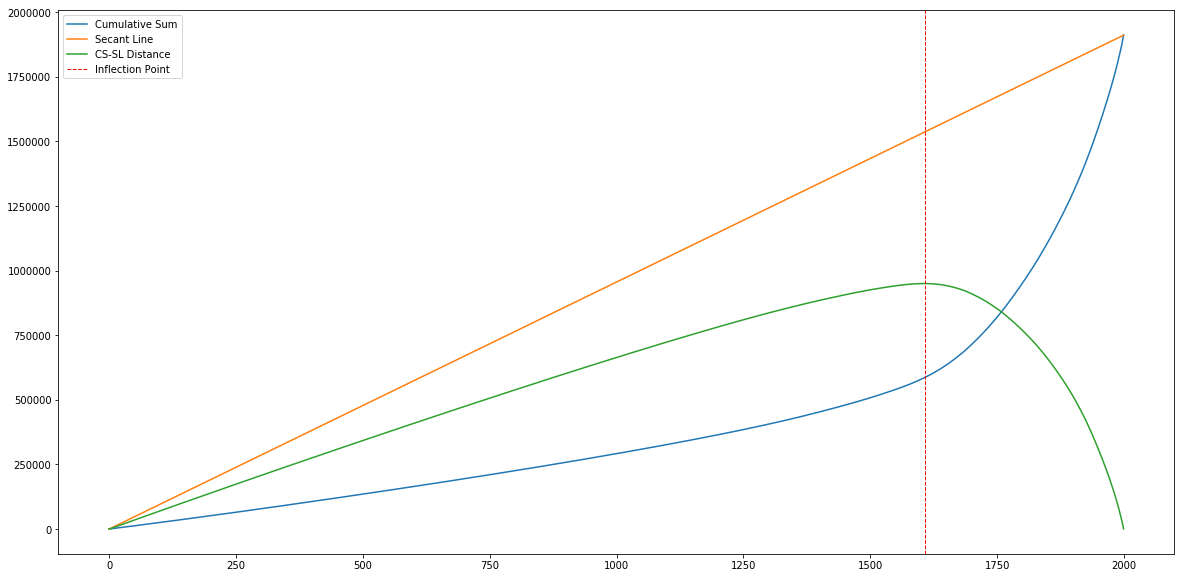

In [13]:
indrops_data.find_inflection()

Here we are storing the initial library size information for comparative analyses later on.

In [14]:
lib_size_before_processing=indrops_data.lib_size

## Post-Inflection Analysis

We need to initialize new QC object with only the top libraries based on inflection point, the libraries to include will depend on how the libraries have been sorted. 

For example, the example dataset here was originally sorted from least to greatest library size, thus we take the last 1500 or so libraries in the dataset (as determined by the inflection point, 2000 - 1500)

A dataset sorted from greatest to least, would likely have an inflection point at 1500 or so, and we would take the first 1500 libraries instead of the last.

The lib_data analysis object is initialized using a pandas DataFrame containing the counts, gene names, and cell barcodes.

In [15]:
indrops_data=lib_data(lib_counts=indrops_data.lib_counts.tail(len(indrops_data.lib_rank)-1500))

In [16]:
indrops_data.lib_counts.head()

,hg19_C1QTNF1,hg19_RP11-706O15.7,mm10_Hnrnpl,hg19_ANXA5,hg19_SHMT2,mm10_mt-Nd5,mm10_Asna1,hg19_COX17,hg19_CD81,hg19_HAGH,...,hg19_C17orf112,hg19_SLC12A1,mm10_Fam83c,hg19_GPR39,hg19_AP000640.2,mm10_1600002D24Rik,hg19_RP11-950C14.7,mm10_RP24-118K20.1,hg19_HCRT,hg19_PDHA2
ACATCTCGTGGGATTC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCAGCCTCAACAATCC,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GACACCTGGGGAGGTA,0,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCAAACTGACCTTGCC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AGGCGTTTGTATGAGT,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Dimensionality Reductions for Downstream Analysis

We pass the lib_data object, indrops_data in this example, to initialize another object for data normalization and dimensionality reductions.

In [17]:
indrops_dr=dimension_reduction(indrops_data,seed=41)

Currently, only an arcsinh based transform and library size normalization is implemented. 

The cofactor, 1000 in this example, affects the linearity of the resulting transformed data. Any values within this range will scale linearly, while values outside of this range will become more log-like.

In [18]:
indrops_dr.normalize_arcsinh(1000)

Linearly reducing the dimensions with PCA enables faster downstream processing with other algorithms such as UMAP or tSNE, here we use 100 components

In [19]:
indrops_dr.runPCA(100)

In [20]:
indrops_dr.runTSNE()

## Clustering and Gating Cell Subpopulations

We pass the dimension_reduction object, indrops_dr, to initialize the clustering and gating based quality control. 

In [21]:
indrops_gt=gate_thresh(indrops_dr)

For the purpose of visualization, we generate overlays based on the percent of counts/cell meeting some criteria defined by a mask, in this case human and mouse mitochondrial genes comprise masks built into the indrops_data object.

In [22]:
human_mt_pct=indrops_data.marker_percent(indrops_data.mt_human_mask)
mouse_mt_pct=indrops_data.marker_percent(indrops_data.mt_mouse_mask)

Next we identify clusters the dimension reduced space, currently only Density Peak Clustering (Rodriguez et al.) is implemented in this pipeline. This is because it is intuitive to use, fast, and can detect non-spherical clusters similar to DBSCAN. Primarily this clustering step is simply to segment the data into gate-able subpopulations.

The points on the decision plot represent cells that act as cluster centers, and are separated based on delta/AU and density. Delta/AU represents the distance between the current cell and any other cell with higher density values. The ratio between this metric provide an intuitive definition of putative clusters.

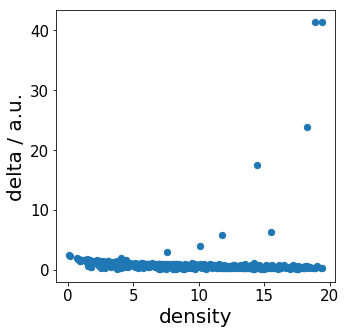

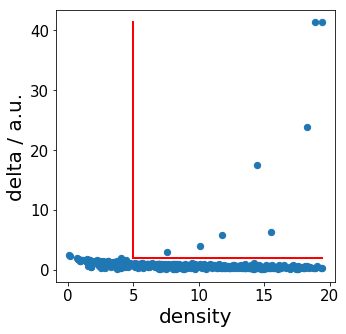

In [23]:
indrops_gt.runDPC(indrops_gt.TSNE,5,2) #the last two values are the x,y cutoffs

In [24]:
indrops_dr.lib_data.head()

,hg19_C1QTNF1,hg19_RP11-706O15.7,mm10_Hnrnpl,hg19_ANXA5,hg19_SHMT2,mm10_mt-Nd5,mm10_Asna1,hg19_COX17,hg19_CD81,hg19_HAGH,...,hg19_C17orf112,hg19_SLC12A1,mm10_Fam83c,hg19_GPR39,hg19_AP000640.2,mm10_1600002D24Rik,hg19_RP11-950C14.7,mm10_RP24-118K20.1,hg19_HCRT,hg19_PDHA2
ACATCTCGTGGGATTC,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCAGCCTCAACAATCC,0.0,0.000000,0.0,0.000000,1.272458,0.000000,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GACACCTGGGGAGGTA,0.0,1.272458,0.0,1.272458,0.000000,1.272458,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCAAACTGACCTTGCC,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AGGCGTTTGTATGAGT,0.0,0.000000,0.0,1.266860,1.266860,0.000000,0.0,0.0,0.0,1.26686,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, we visualize the overlays, ordinal library quality, and DPC defined clusters. 

This example dataset contains both human and mouse transcripts, so we must visualize using both our mouse and human mitochondrial overlays that we defined earlier.

With respect to library quality, the higher the rank value, the lower the quality, as they were ranked from highest to lowest library sizes with an argsort. 

The third set of plots simply demonstrates that other marker overlays can also be used to pinpoint the expression of genes of interest, Igf2 is visualized here for example. 

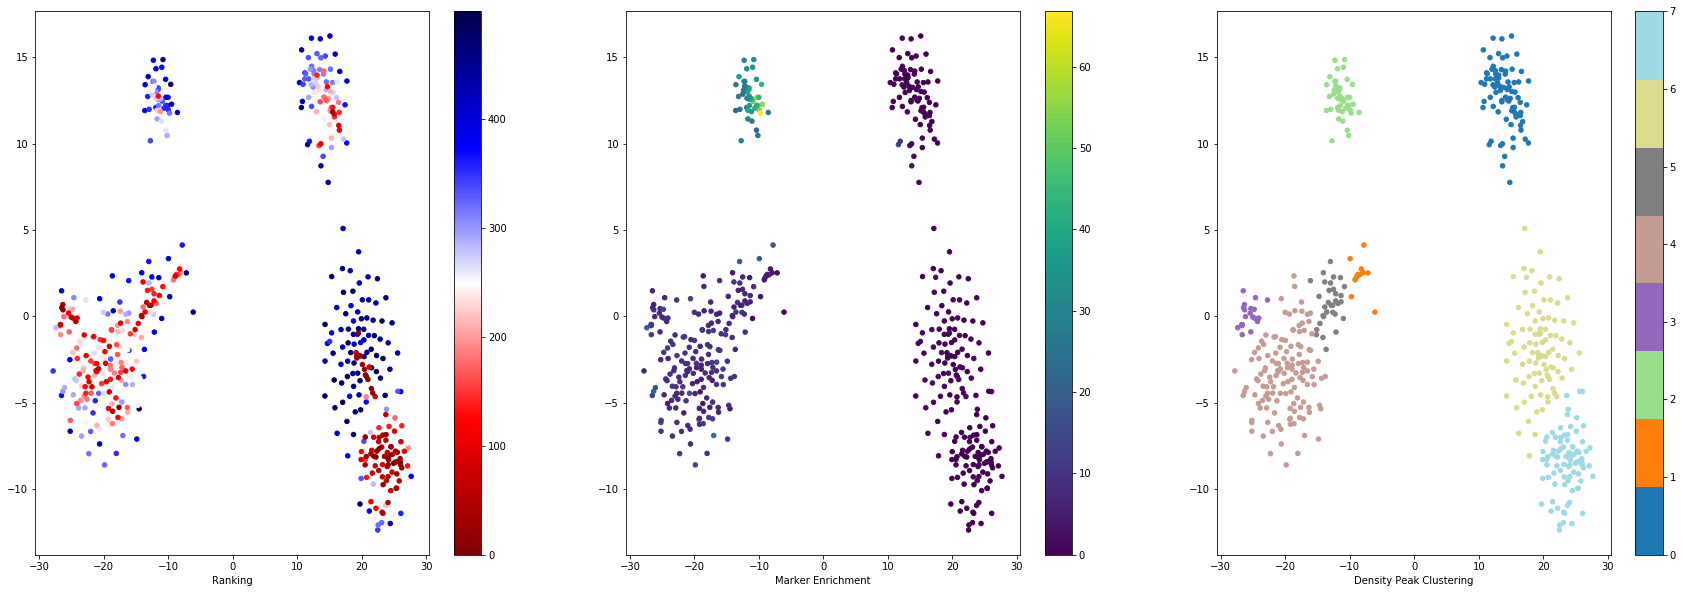

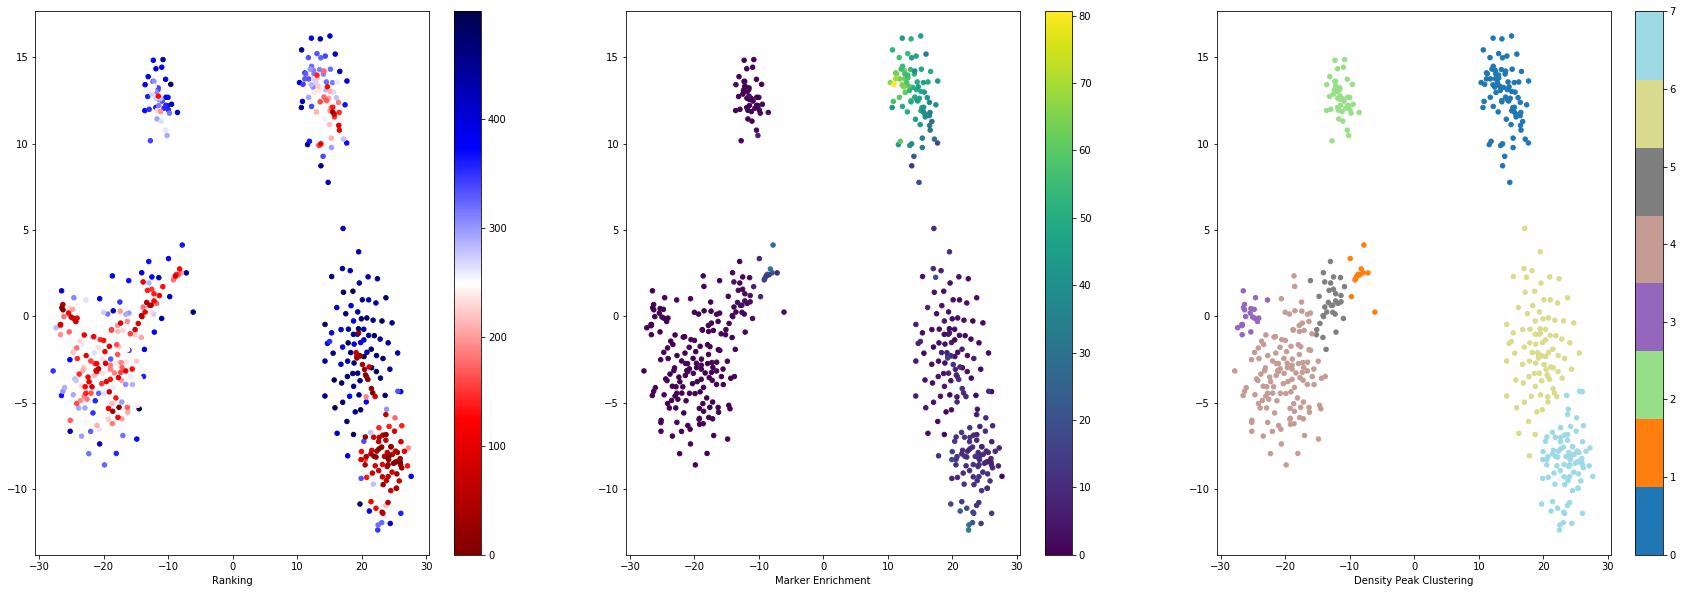

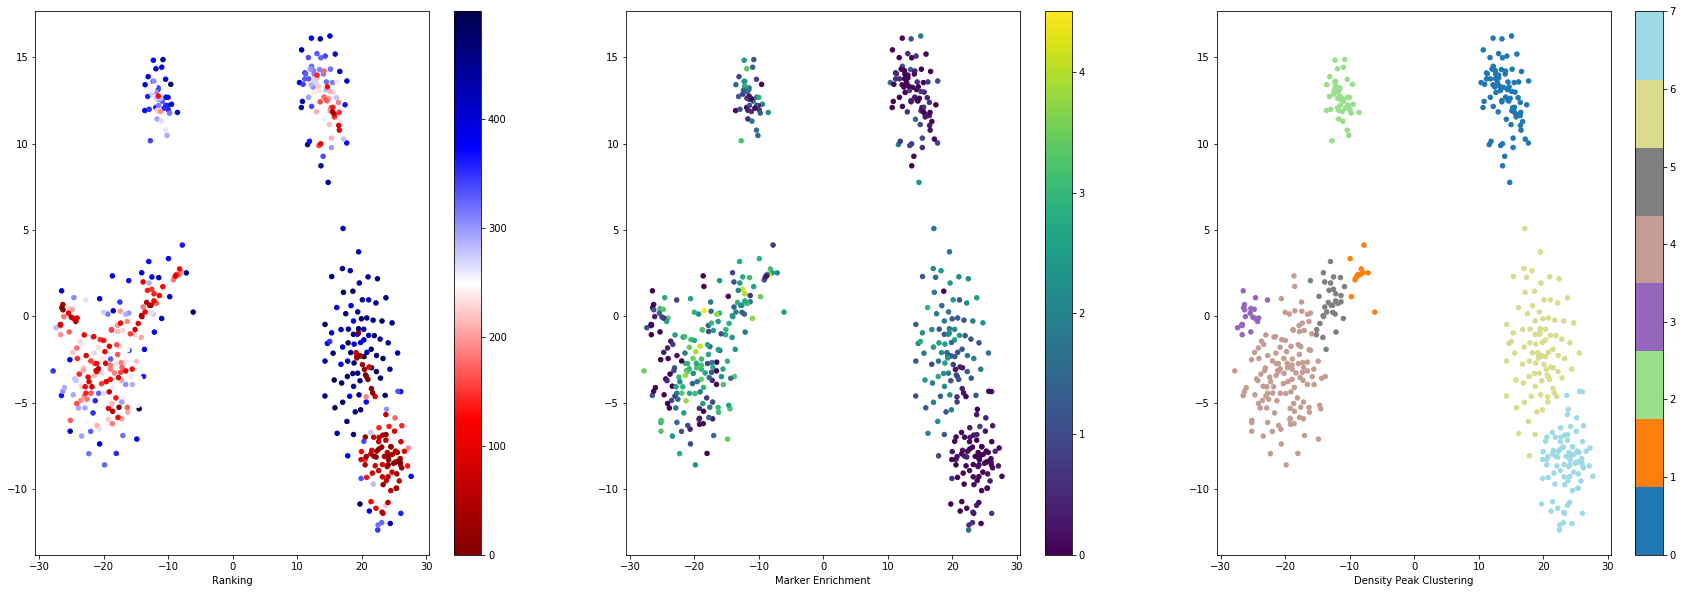

In [25]:
indrops_gt.plotTSNE(mouse_mt_pct) 
indrops_gt.plotTSNE(human_mt_pct)
indrops_gt.plotTSNE(indrops_dr.lib_data['mm10_Igf2'])

Next we must gate out low quality or dead cells as defined by library size and the aggregate mitochondrial markers (mouse and human respectively)

Here we gate out the following subpopulations:

0, 1 and, 2 for high mouse and human mitochondrial expression

6 for low library size

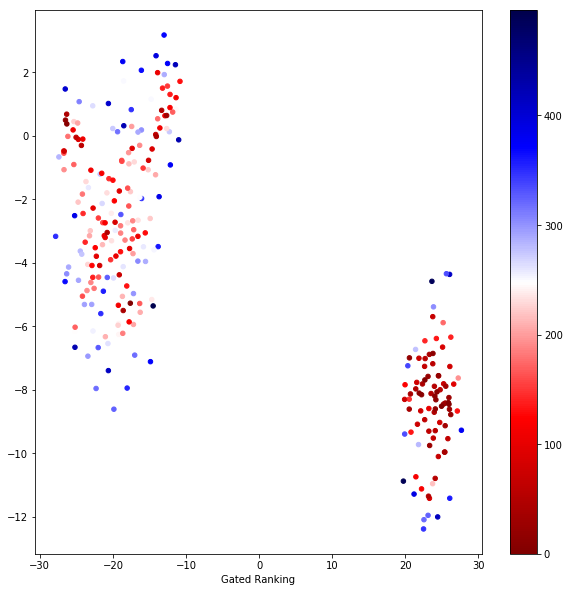

In [26]:
gated_indices=indrops_gt.manual_gating([0,1,2,6])

Now that we have the indices of the desired cell subpopulations, we initialize a new lib_data object with the new subset of cells, this is because we need to perform another set of dimensionality reductions to properly visualize the data after having changed its global structure by removing undesireable cell subpopulations. 

In [27]:
gated_indrops_data=lib_data(lib_counts=indrops_data.lib_counts[gated_indices]) #make new gated object

For the sake of example, here we generate a couple new masks/overlays that will show human vs. mouse transcripts

In [28]:
mouse_gene_mask=pd.Series(gated_indrops_data.lib_counts.columns.str.contains("mm10_")).values
human_gene_mask=pd.Series(gated_indrops_data.lib_counts.columns.str.contains("hg19_")).values

In [29]:
human_pct_gated=gated_indrops_data.marker_percent(human_gene_mask)
mouse_pct_gated=gated_indrops_data.marker_percent(mouse_gene_mask)

## Re-running dimensionality reduction and visualizing QC'd Data

We repeat the procedure of initializing a dimension_reduction object, the normalizations/transformations that take place, and the dim. reductions but this time with just the cells of interest remaining after our first gating procedure.

In [30]:
gated_indrops_dr=dimension_reduction(gated_indrops_data)

In [31]:
gated_indrops_dr.normalize_arcsinh(1000)

In [32]:
gated_indrops_dr.runPCA(100)

In [33]:
gated_indrops_dr.runTSNE()

In [34]:
gated_indrops_gt=gate_thresh(gated_indrops_dr)

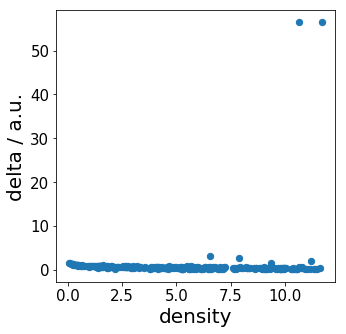

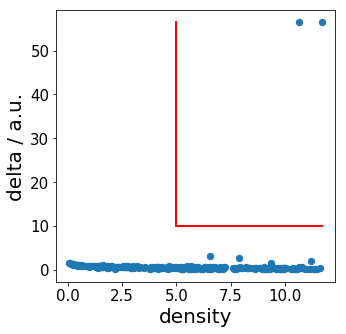

In [35]:
gated_indrops_gt.runDPC(gated_indrops_gt.TSNE,5,10)

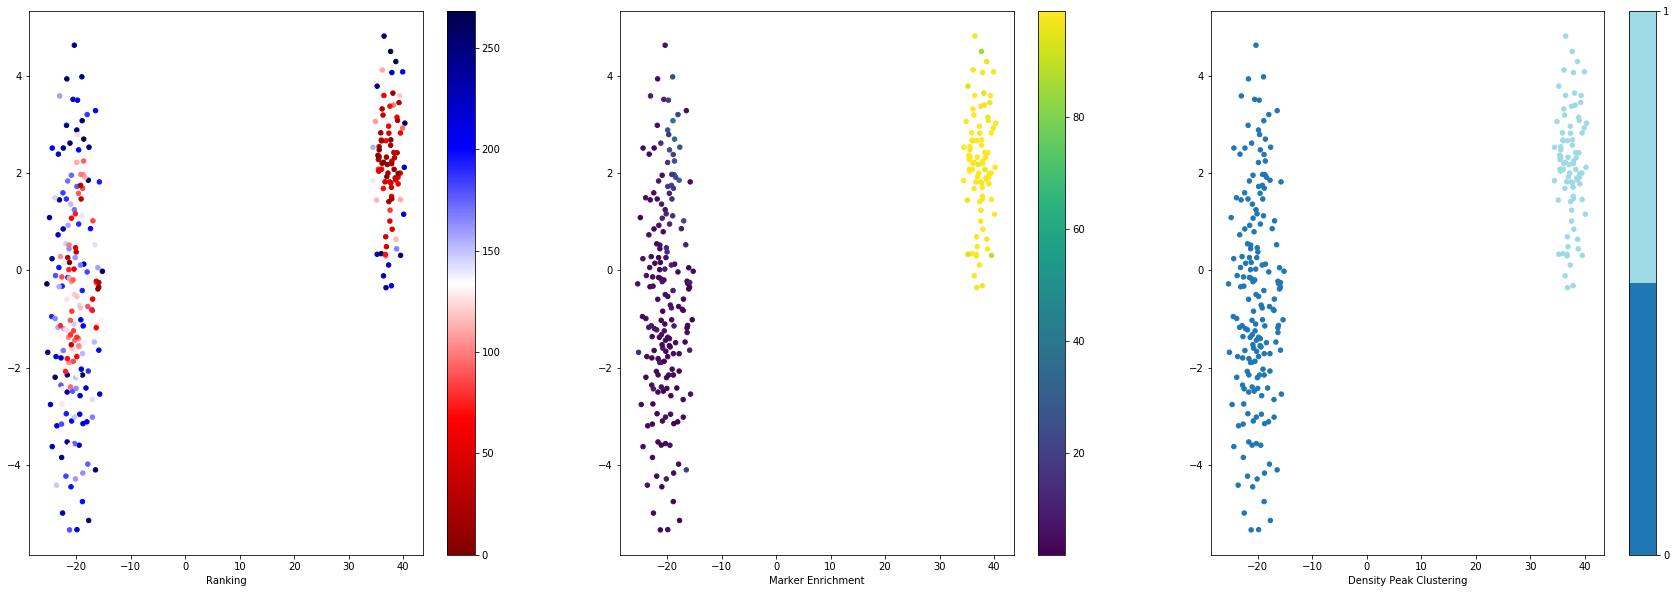

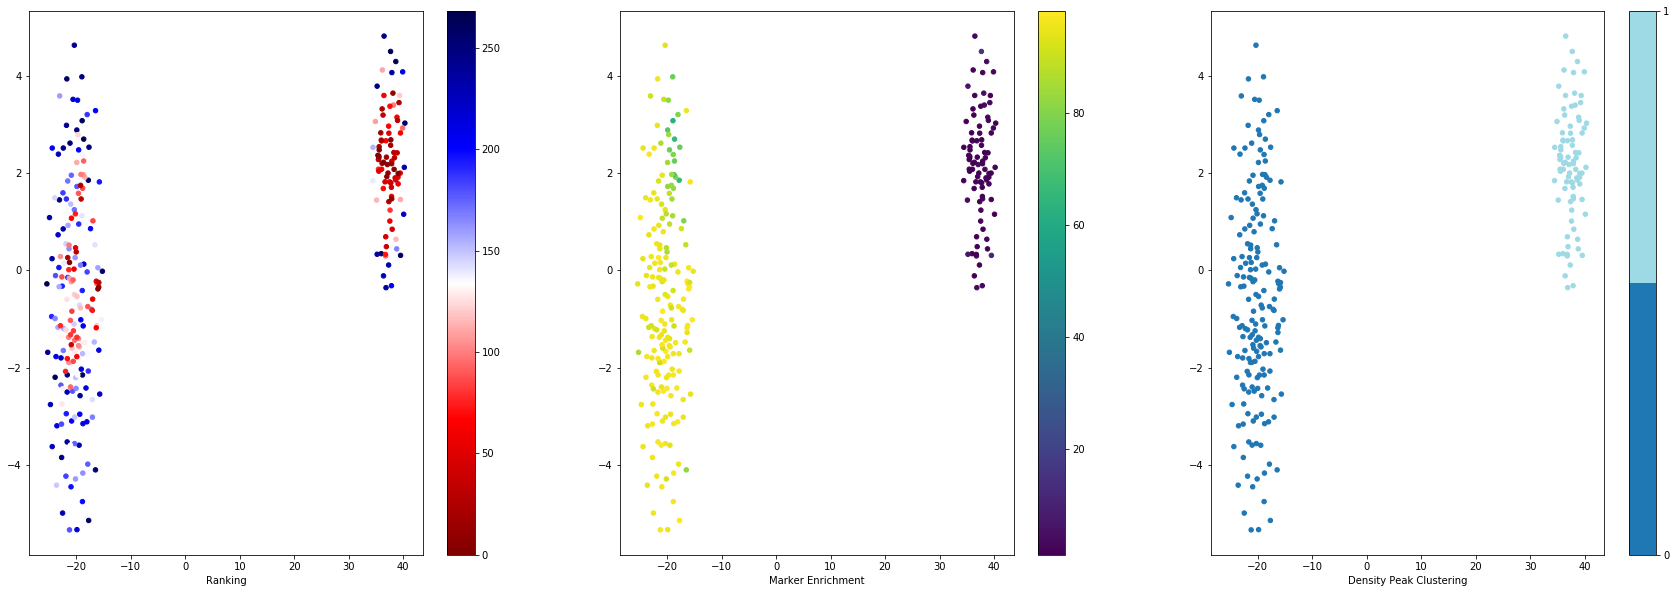

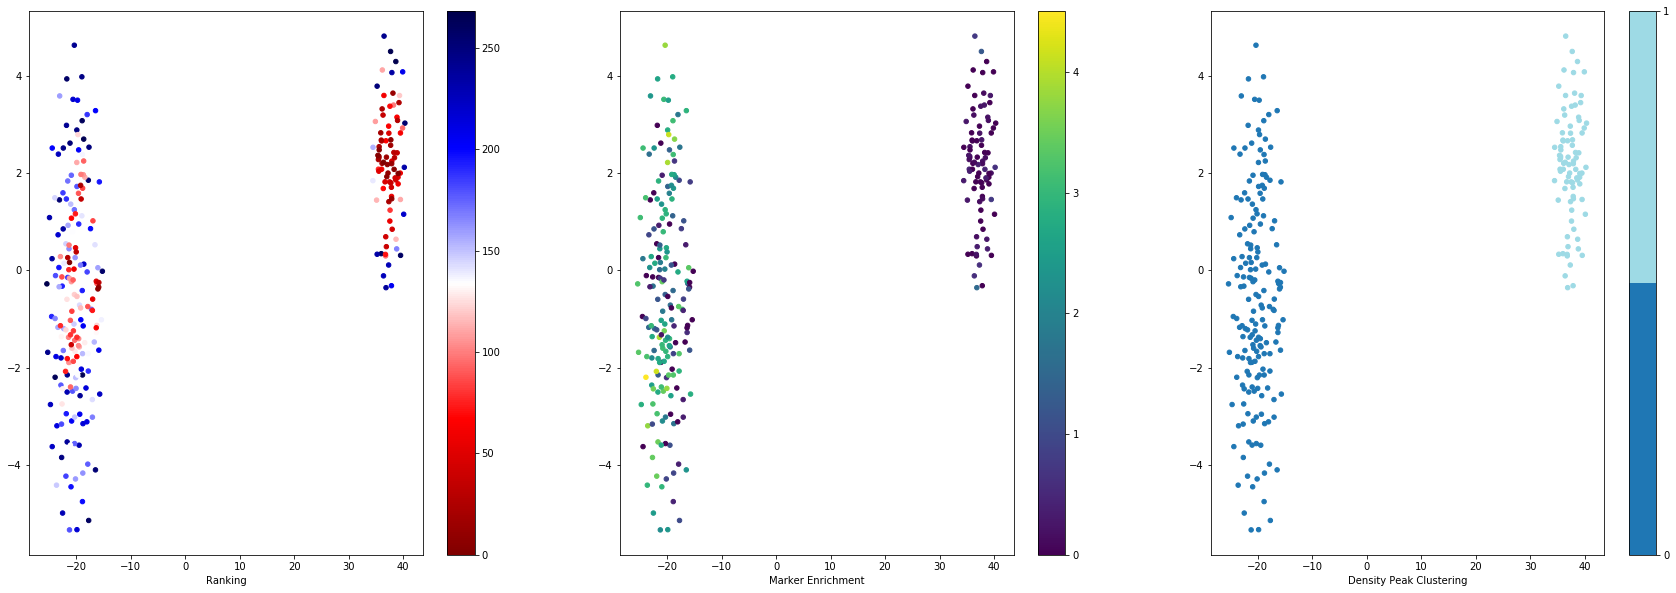

In [36]:
gated_indrops_gt.plotTSNE(human_pct_gated)
gated_indrops_gt.plotTSNE(mouse_pct_gated)
gated_indrops_gt.plotTSNE(gated_indrops_dr.lib_data['mm10_Igf2'])

If things are up to par, we can go ahead and write this new set of points to a file.

This part is up to the user's discretion, as each experiment will necessitate different populations of cells, which can be pinpointed through overlays of choice.

## Final check visualizing dataset library quality at each step of processing

Text(0.5, 0, 'Number of UMIs')

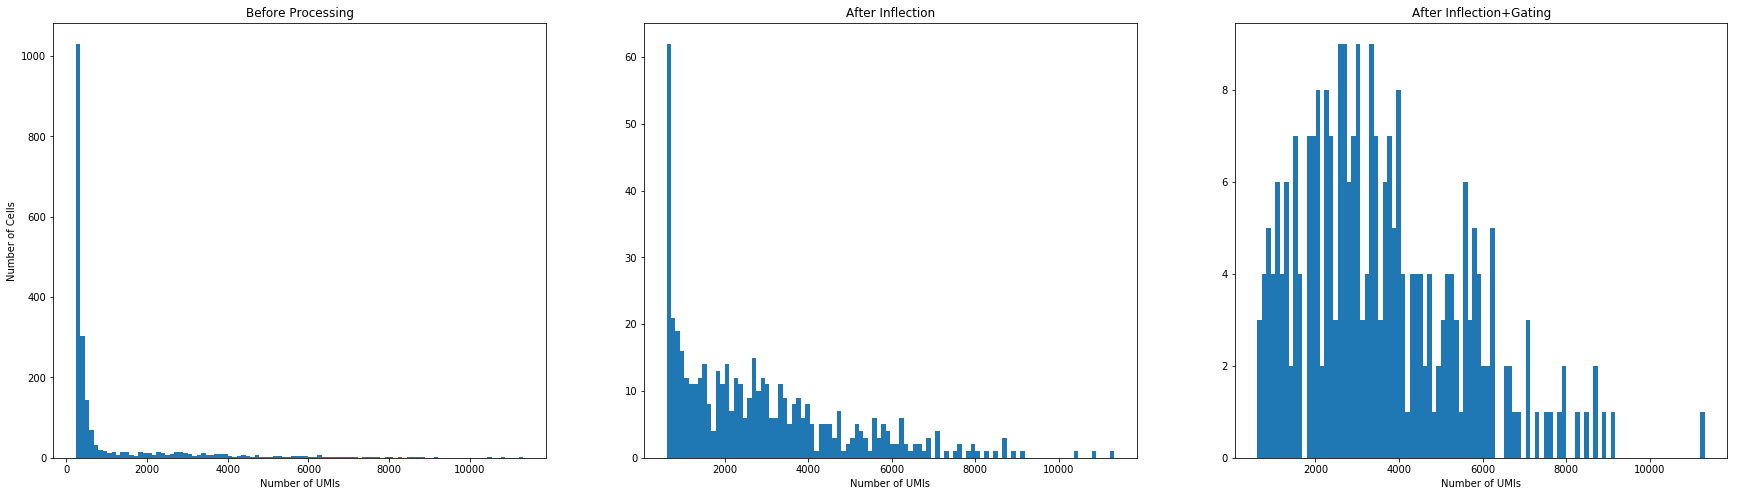

In [37]:
fig = plt.figure(figsize=(30,8))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.hist(lib_size_before_processing,bins=100)
ax2.hist(indrops_data.lib_size,bins=100)
ax3.hist(gated_indrops_data.lib_size,bins=100)

ax1.set_title("Before Processing")
ax1.set_ylabel("Number of Cells")
ax1.set_xlabel("Number of UMIs")
ax2.set_title("After Inflection")
ax2.set_xlabel("Number of UMIs")
ax3.set_title("After Inflection+Gating")
ax3.set_xlabel("Number of UMIs")

In [38]:
summary=pd.DataFrame([gated_indrops_data.lib_size.describe(),indrops_data.lib_size.describe(),lib_size_before_processing.describe()])

In [39]:
summary.index=['UMIs After_Inflection+Gating','UMIs After_Inflection','UMIs Before_Processing']
summary

,count,mean,std,min,25%,50%,75%,max
UMIs After_Inflection+Gating,269.0,3589.249071,1940.912047,609.0,2168.00,3299.0,4757.0,11322.0
UMIs After_Inflection,500.0,2809.268000,2033.568143,607.0,1107.75,2349.0,3819.5,11322.0
UMIs Before_Processing,2000.0,956.159000,1477.310684,238.0,290.00,344.0,607.0,11322.0


Here we just have some general information about how the dataset has changed at each step of QC.

Now we can do a final check on the QC'd library in preparation for writing it to a file.

In [40]:
gated_indrops_data.lib_counts.head()

,hg19_C1QTNF1,hg19_RP11-706O15.7,mm10_Hnrnpl,hg19_ANXA5,hg19_SHMT2,mm10_mt-Nd5,mm10_Asna1,hg19_COX17,hg19_CD81,hg19_HAGH,...,hg19_C17orf112,hg19_SLC12A1,mm10_Fam83c,hg19_GPR39,hg19_AP000640.2,mm10_1600002D24Rik,hg19_RP11-950C14.7,mm10_RP24-118K20.1,hg19_HCRT,hg19_PDHA2
GCAAACTGACCTTGCC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GAATCCCAGTTGTCAT,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AATCCGGCCCAACCGT,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
ATATGGGTCACGGACT,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GCAAACTGAACTTAGC,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's also check which directory we're in:

In [41]:
import os
os.getcwd()

'/Users/darren/Documents/git_repos/QSBSC/Python_code/Lau/QC'

and, write the file:

In [42]:
gated_indrops_data.lib_counts.to_csv("Quality_Controlled_Indrops_Data.csv")